In [205]:
import pandas as pd 
from pandas import read_csv
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import os

In [206]:
climate = pd.read_csv('DC.csv')
climate.head()


,Unnamed: 0,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,year
0,1,USC00186350,"NATIONAL ARBORETUM DC, MD US",38.91329,-76.97009,15.2,1973-01-01,0.00,0.0,0.0,64.0,46.0,46.0,1973
1,4,USC00186350,"NATIONAL ARBORETUM DC, MD US",38.91329,-76.97009,15.2,1973-01-02,0.00,0.0,0.0,63.0,38.0,43.0,1973
2,7,USC00186350,"NATIONAL ARBORETUM DC, MD US",38.91329,-76.97009,15.2,1973-01-03,0.00,0.0,0.0,45.0,24.0,37.0,1973
3,10,USC00186350,"NATIONAL ARBORETUM DC, MD US",38.91329,-76.97009,15.2,1973-01-04,0.52,0.0,0.0,51.0,32.0,50.0,1973
4,13,USC00186350,"NATIONAL ARBORETUM DC, MD US",38.91329,-76.97009,15.2,1973-01-05,0.00,0.0,0.0,51.0,38.0,44.0,1973


In [207]:
climate = climate.drop(['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION','DATE','PRCP','SNOW','SNWD','TMAX','TMIN','year'], axis = 1)
climate.to_csv('DC2.csv', index = False)  
climate.head()

,Unnamed: 0,TOBS
0,1,46.0
1,4,43.0
2,7,37.0
3,10,50.0
4,13,44.0


In [208]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model_type = input("Enter a model: RNN, RNN-RE, LSTM, LSTM-RE, GRU, or GRU-RE")

def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

# RNN
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# GRU
def create_GRU(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# LSTM
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# RNN Regularization
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0], kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# GRU Regularization
def create_GRU(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape, activation=activation[0], kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# LSTM Regularization
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation[0], kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def print_error(trainY, testY, train_predict, test_predict):    
    # Calculate the error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))  

def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation Number After Given Time Steps')
    plt.ylabel('Temperature')
    plt.title('Monthly Temperature in Washington DC: Actual and Predicted Values')
    plt.show()  

In [209]:
import random
random.seed(1234)

dataframe_ts = ('DC2.csv')
time_steps = 60 ## 1 ## 5 ## 25 ## 365 
train_data, test_data, data = get_train_test(dataframe_ts)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)
 
if model_type == "RNN":
    model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
elif model_type == "RNN-RE":
    model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
elif model_type == "GRU":
    model = create_GRU(hidden_units=3, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
elif model_type == "GRU-RE":
    model = create_GRU(hidden_units=3, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
elif model_type == "LSTM":
    model = create_LSTM(hidden_units=3, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
else:
    model = create_LSTM(hidden_units=3, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh'])

history = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)


Epoch 1/20
 - 4s - loss: 0.1496
Epoch 2/20
 - 3s - loss: 0.0600
Epoch 3/20
 - 3s - loss: 0.0367
Epoch 4/20
 - 3s - loss: 0.0271
Epoch 5/20
 - 3s - loss: 0.0226
Epoch 6/20
 - 3s - loss: 0.0200
Epoch 7/20
 - 3s - loss: 0.0175
Epoch 8/20
 - 3s - loss: 0.0154
Epoch 9/20
 - 3s - loss: 0.0153
Epoch 10/20
 - 3s - loss: 0.0150
Epoch 11/20
 - 3s - loss: 0.0142
Epoch 12/20
 - 3s - loss: 0.0143
Epoch 13/20
 - 3s - loss: 0.0140
Epoch 14/20
 - 3s - loss: 0.0138
Epoch 15/20
 - 3s - loss: 0.0133
Epoch 16/20
 - 3s - loss: 0.0146
Epoch 17/20
 - 3s - loss: 0.0137
Epoch 18/20
 - 3s - loss: 0.0143
Epoch 19/20
 - 3s - loss: 0.0139
Epoch 20/20
 - 3s - loss: 0.0134


In [210]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

Train RMSE: 0.113 RMSE
Test RMSE: 0.102 RMSE


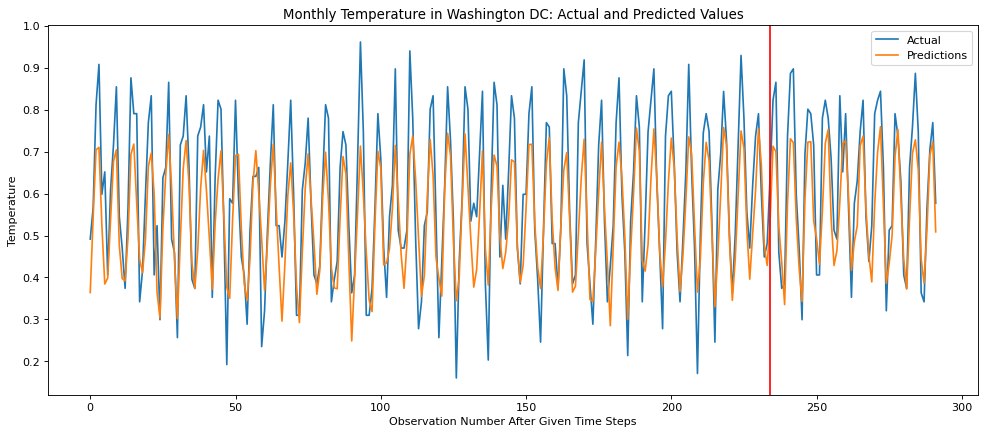

In [211]:
## Get and print error values 
print_error(trainY, testY, train_predict, test_predict)

## Plot the final model result 
plot_result(trainY, testY, train_predict, test_predict)

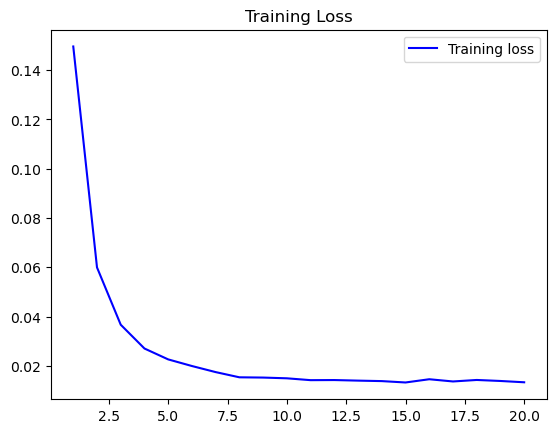

In [212]:
import matplotlib.pyplot as plt

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training Loss')
plt.legend()

plt.show()